In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [213]:
# Função para carregar o conjunto de dados
def load_data():
  # Lista para armazenar os DataFrames individuais
  dfs = []

  # Carregar os dados
  for year in range(2007, 2025):
    file_path = f'./data/INMET_MG_PAMPULHA_{year}.csv'
    df = pd.read_csv(file_path, sep=';', encoding='latin1')

    # Adicionar o DataFrame lido à lista
    dfs.append(df)

  # Concatenar todos os DataFrames em um único DataFrame
  data = pd.concat(dfs, ignore_index=True)

  # Renomear colunas
  data.columns = ['Data', 'Hora', 'Precipitação', 'Pressão Atmosférica', 'Pressão Atmosférica MAX Hora Ant.',
                  'Pressão Atmosférica MIN Hora Ant.', 'Radiação', 'Temperatura Ar', 'Temperatura Orvalho', 
                  'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 'Temperatura Orvalho MAX Hora Ant.', 
                  'Temperatura Orvalho MIN Hora Ant.', 'Humidade MAX Hora Ant.', 'Humidade MIN Hora Ant.',
                  'Humidade', 'Direção Vento', 'Rajada Vento', 'Velocidade Vento']

  # Remover "UTC" da coluna de tempo
  data['Hora'] = data['Hora'].str.replace(' UTC', '')
  # Converter a hora do formato "HHMM" para "HH:MM"
  data['Hora'] = data['Hora'].apply(lambda x: f"{x[:2]}")
  # Converter data e hora para datetime
  data['datetime'] = pd.to_datetime(data['Data'] + ' ' + data['Hora'], format='%d/%m/%Y %H')
  # Conversão para Unix Timestamp
  data['unix_timestamp'] = data['datetime'].apply(lambda dt: dt.timestamp())

  # Definir 'datetime' como índice e remover as colunas originais de data e hora
  data = data.set_index('datetime')
  data = data.drop(columns=['Data', 'Hora'])

  # Preencher valores ausentes
  data = data.replace(-9999, np.nan)
  data = data.ffill().bfill()

  return data

In [214]:
data = load_data()

# # Selecionar colunas relevantes
# # DAta e Hora - Temperatura do ar - Humidade - Pressao - Velocidade do Vento - Direcao do Vento - Radiacao Solar - Precipitacao
# relevant_data = ['unix_timestamp', 'temp_air', 'humidity', 'pressure_station', 'wind_speed', 'wind_direction', 'radiation', 'precipitation']

# Remover linhas com NaN e o índice
data = data.dropna()

# Salva os dados relevantes para o treinamento em um novo arquivo csv
data.to_csv('relevant_data.csv', sep=';', encoding='latin1')

In [215]:
new_data = pd.read_csv('relevant_data.csv', sep=';', encoding='latin1')
new_data = new_data.set_index('datetime')

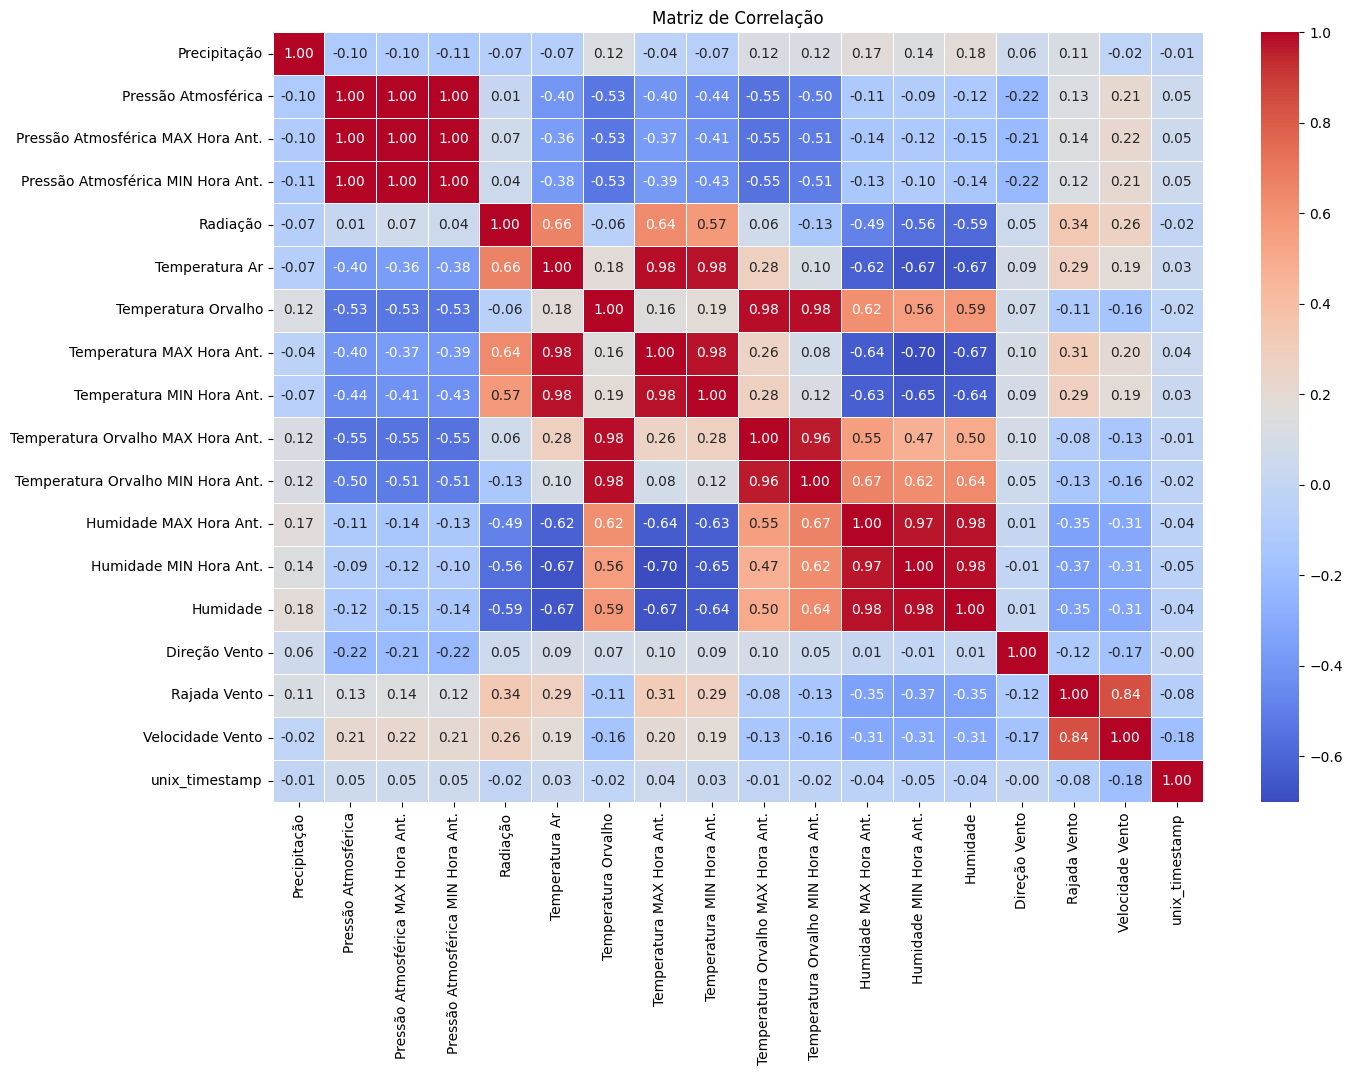

In [216]:
correlation_matrix = new_data.corr()

# Configura o tamanho do gráfico
plt.figure(figsize=(15, 10))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título do gráfico
plt.title("Matriz de Correlação")

# Mostra o gráfico
plt.show()


In [224]:
# Prepara os dados para o treinamento

X = new_data.drop(columns=['Temperatura Ar', 'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.'], axis=1).values
y = new_data['Temperatura Ar'].values

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normaliza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar o shape dos dados divididos
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (122131, 15)
Shape de X_test: (30533, 15)
Shape de y_train: (122131,)
Shape de y_test: (30533,)


In [225]:
# Rede Neural
model = Sequential([
  InputLayer(shape=(X_train.shape[1], 1)),
  Conv1D(filters=64, kernel_size=2, activation='relu'),
  MaxPooling1D(pool_size=1),
  Flatten(),
  Dense(32, activation='relu'),
  Dense(1)
])

model.compile(optimizer='adam', loss='mae', metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=50)

history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 7.9893 - mse: 133.7475 - val_loss: 0.4585 - val_mse: 0.5210
Epoch 2/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.3167 - mse: 0.2836 - val_loss: 0.2655 - val_mse: 0.2516
Epoch 3/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2188 - mse: 0.1655 - val_loss: 0.1870 - val_mse: 0.1580
Epoch 4/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1696 - mse: 0.1001 - val_loss: 0.2298 - val_mse: 0.1317
Epoch 5/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1465 - mse: 0.0747 - val_loss: 0.1455 - val_mse: 0.0912
Epoch 6/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1267 - mse: 0.0558 - val_loss: 0.1318 - val_mse: 0.0706
Epoch 7/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1284 - mse: 0.0515 - val_loss: 0.1234 - val_mse: 0.0612
Epoch 8/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1167 - mse: 0.0438 - val_loss: 0.1169 - val_mse: 0.0547
Epoch 9/500
382/382 ━━━━━━━━━━━━━━━━━

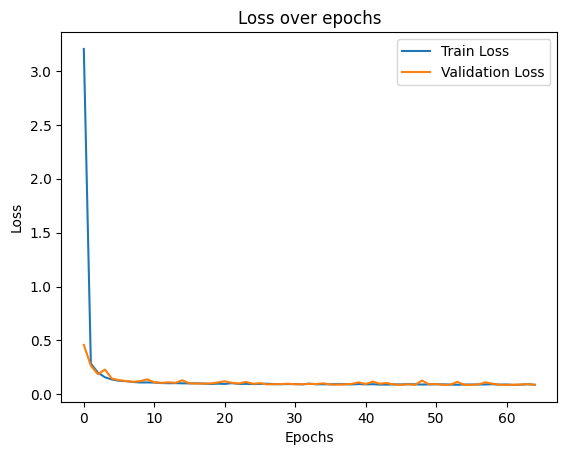

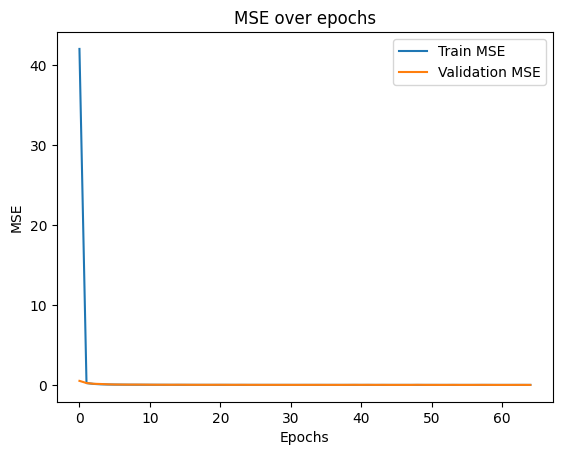

In [226]:
# Plotar a perda
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotar R²
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('MSE over epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [228]:
# Avaliar o modelo
mae, mse = model.evaluate(X_test, y_test)
print(f'Model loss (MAE): {mae} \nMSE: {mse}')

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R square (R²): {r2}')

955/955 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0948 - mse: 0.0179
Model loss (MAE): 0.1055513322353363 
MSE: 0.021013138815760612
955/955 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
R square (R²): 0.998824967684267


In [223]:
predictions = model.predict(X_test)
rounded_predictions = np.round(predictions, decimals=1)

for i in range( len(rounded_predictions) ):
  print(f'Valor previsto: {rounded_predictions[i][0]:.1f}, Valor real: {y_test[i]}')


955/955 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Valor previsto: 23.7, Valor real: 23.8
Valor previsto: 23.1, Valor real: 23.2
Valor previsto: 22.5, Valor real: 22.6
Valor previsto: 22.6, Valor real: 22.6
Valor previsto: 22.3, Valor real: 22.3
Valor previsto: 22.5, Valor real: 22.5
Valor previsto: 22.0, Valor real: 21.9
Valor previsto: 21.6, Valor real: 21.6
Valor previsto: 21.5, Valor real: 21.5
Valor previsto: 21.3, Valor real: 21.4
Valor previsto: 21.3, Valor real: 21.2
Valor previsto: 20.8, Valor real: 20.7
Valor previsto: 20.8, Valor real: 20.8
Valor previsto: 20.6, Valor real: 20.7
Valor previsto: 21.0, Valor real: 21.0
Valor previsto: 22.3, Valor real: 22.3
Valor previsto: 23.6, Valor real: 23.7
Valor previsto: 24.5, Valor real: 24.4
Valor previsto: 26.1, Valor real: 26.3
Valor previsto: 21.0, Valor real: 20.8
Valor previsto: 22.2, Valor real: 22.3
Valor previsto: 24.0, Valor real: 23.9
Valor previsto: 25.3, Valor real: 25.5
Valor previsto: 24.8, Valor real: 24.7
Valor previsto: 22.0, V